# Simulation Code

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def simulation(beta=0.75, gamma=0.2, days=100, public_trans=0.56, public_trans_vec=None, plot=False, verbose=False):
    # Read in origin-destination flow matrix
    #OD = np.genfromtxt('data/Yerevan_OD_coronavirus.csv', delimiter=',')
    OD = np.genfromtxt('data/nyc_od.csv', delimiter=',')


    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh=200
    first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
    # NOTE: this is arbitrary but not actually random.... 
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = beta         # Number of ppl an infectious person infects per day
    gamma = gamma        # 1/how many days you would infect ppl for (0.2 assumes 5 days, and that people quarantine once symptoms develop) 
    public_trans = public_trans                                # alpha (how many people are moving around)
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)   # gamma dist multiplies beta * 2 to give a mean of 1.5
    gamma_vec = np.full(locs_len, gamma)
    if public_trans_vec is None:
        public_trans_vec = np.full(locs_len, public_trans)

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    infected_pop_norm = []
    susceptible_pop_norm = []
    recovered_pop_norm = []

#     for time_step in tqdm(range(days)):
    for time_step in range(days):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        if verbose:
            print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        if verbose:
            print(f'S:{S}, I:{I}, R:{R}, (S+I+R)*N_k.sum():{(S+I+R)*N_k.sum()}, N_k.sum():{N_k.sum()}')
            print('\n')
        infected_pop_norm.append(I)
        susceptible_pop_norm.append(S)
        recovered_pop_norm.append(R)

    # plot results
    if plot==True:
        fig = plt.figure()
        ax = plt.axes()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.plot(np.arange(days), susceptible_pop_norm, label='Susceptible', color='#4aa5f0', linewidth=2)
        ax.plot(np.arange(days), infected_pop_norm, label='Infected', color='#f03737', linewidth=2)
        ax.plot(np.arange(days), recovered_pop_norm, label='Recovered', color='#82e88a', linewidth=2)
        ax.plot(np.arange(days), public_trans_vec, '--', label='public_trans_vec', color='k', linewidth=2)
        ax.legend(frameon=False)
        ax.set_xlabel("Days")
        ax.set_ylabel("Share of Population")
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        #ax.figure.savefig('figures/sir_plot.png')
        plt.show()

# Estimating public_trans_vec

56% of the population of NYC uses the public transportation system. Thus, we initially set public_trans 
to 0.56. The earliest reported symptoms of a confirmed case occurred on Feb 22nd, and we estimate that the 
individual was infected 5 days prior (Feb 17th). This will mark the first day of our simulation, although 
there were likely infections prior to this date, since the infected individual did not travel anywhere 
prior to contracting the virus. NYC limited transportation of non-essential workers on March 22nd, 34 days 
later. This is reflected by lowering the public_trans value on the 34th day of the simulation. 
Reports from the MTA have stated that from February, subway ridership fell by 60% as of 
March 17th, and 92% by April 8th, and 93% by April 17th. We can use these values to estimate public_trans 
over time. <br><br>


#### Timeline
Day &emsp; Ridership <br>
1 &emsp;&emsp;&nbsp;  100% <br>
19 &emsp;&emsp;100% (March 7th -- state of emergency declared -- this is when ridership likely started falling) <br>
29 &emsp;&emsp; 40% (March 17th) <br>
51 &emsp;&emsp; 8%  (Aprile 8th) <br>
60 &emsp;&emsp; 7%  (April 17th) <br>
88 &emsp;&emsp; 28%  (May 15th -- possible lifting of stay-at-home restrictions) <br>
<br>
Sources: <br>
https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_New_York_(state)#Timeline <br>
https://nytransit.org/resources/public-transit-facts <br>
https://comptroller.nyc.gov/reports/new-york-citys-frontline-workers/<br>
http://web.mta.info/nyct/facts/ridership/ <br>
https://www.businessinsider.com/coronavirus-nyc-subway-ridership-craters-amid-coronavirus-mta-seeks-bailout-2020-3 <br>
https://www.businessinsider.com/new-york-subway-rides-plunge-mta-requests-second-bailout-93-2020-4 <br>
https://brooklyneagle.com/articles/2020/04/08/new-york-city-subway-ridership-down-92-percent-due-to-coronavirus/

#### MTA ridership over time

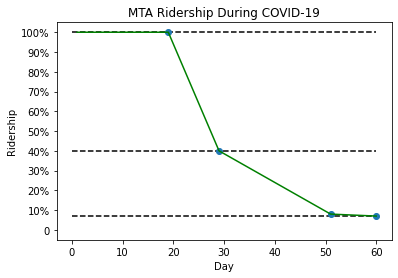

In [14]:
# approximate ridership percentages over time 
from scipy.interpolate import interp1d
%matplotlib inline

earlier_start = 0    # days before Feb 22 (day of Patient-0's first reported symptoms)
x = [19+earlier_start, 29+earlier_start, 51+earlier_start, 60+earlier_start]
y = [1, .4, .08, .07]
f = interp1d(x, y)
plt.plot(x, y, 'o')
plt.xlabel('Day')
plt.ylabel('Ridership')
new_y = np.append([1], f(x))
x = np.append([1], x)
plt.plot(x, new_y, 'g', '-')
plt.yticks(np.arange(0,1.1, step=0.1), ['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
plt.hlines([1, .4, .07], 0, 60+earlier_start, linestyles='--')
plt.title('MTA Ridership During COVID-19')
plt.show()

#### Generating public_trans_vec using MTA ridership

Text(0.5, 1.0, 'Percent of New Yorkers using MTA')

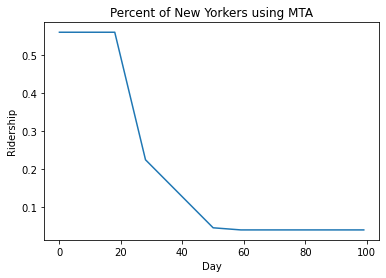

In [13]:
'''
Append values for days before and after the interpolated values (1s before, .07 after). Then, multiply by public_trans to get public_trans_vec.
'''
days = 100

# append values for days before and after periods of decreasing ridership
ridership = np.append(np.ones(18+earlier_start), f(np.arange(19+earlier_start,61+earlier_start)))
ridership = np.append(ridership, np.full(days-len(ridership), .07))

# multiply by public_trans to get public_trans_vec
public_trans = 0.56 
public_trans_vec = ridership * public_trans

# plot
plt.plot(np.arange(0,100+earlier_start), public_trans_vec)
plt.xlabel('Day')
plt.ylabel('Ridership')
plt.title('Percent of New Yorkers using MTA')

## Simulations

In [24]:
# generate public_trans_vec
def generate_ptv(public_trans=0.56, earlier_start=0, days=100, reopen_day=88, reopen_val=None, plot=False):
    # earlier_start: days before Feb 22 (day of Patient-0's first reported symptoms)
    # public_trans: baseline % of population using public transit during normal times
    # days: days to run simulation for
    x = [19+earlier_start, 29+earlier_start, 51+earlier_start, 60+earlier_start]
    y = [1, .4, .08, .07]
    f = interp1d(x, y)
    # append values for days before and after periods of decreasing ridership
    ridership = np.append(np.ones(18+earlier_start), f(np.arange(19+earlier_start,61+earlier_start)))
    if reopen_val is None:
        reopen_val = .07
    ridership = np.append(ridership, np.full(days-len(ridership), reopen_val))
    # multiply ridership by public_trans to get public_trans_vec, appedn to reopen_vals
    public_trans_vec = np.append(ridership * public_trans, np.full(days-len(ridership), reopen_val))
    if plot:
        plt.plot(np.arange(0,days+earlier_start), public_trans_vec)
        plt.xlabel('Day')
        plt.ylabel('Ridership')
        plt.title('Percent of New Yorkers using MTA')
        plt.show()
    return public_trans_vec

def run_sim(public_trans=.56, beta=0.75, gamma=0.2, days=100, reopen_day=88, reopen_val=None, plot=False):
    if reopen_val is None:
        reopen_val = .07
    ptv = generate_ptv(public_trans=public_trans, days=days, earlier_start=earlier_start, reopen_day=reopen_day, reopen_val=reopen_val, plot=plot)
    simulation(beta=beta, gamma=gamma, days=days, public_trans=public_trans, public_trans_vec=ptv, plot=plot)

#### Travel remains restricted

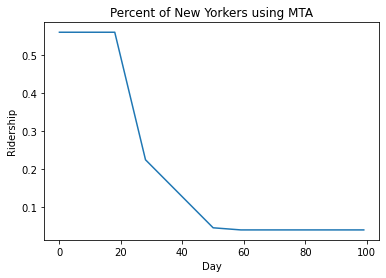

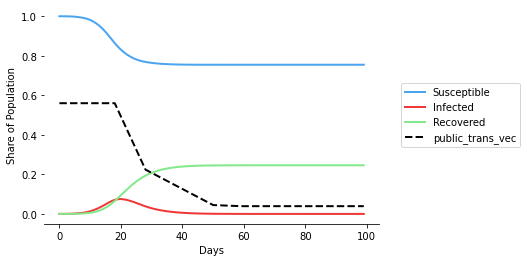

In [25]:
run_sim(public_trans=.56, beta=0.75, gamma=0.2, days=100, reopen_day=88, plot=True)

### Lifting stay-at-home restrictions 
Next, we can simulate the effects of NYC re-opening. In order to do this, we need to set both a date for
the lifting of travel restrictions, and estimate how public transportation will be re-adopted over time.
The current stay-at-home restrictions expire on May 15th, so we can use this as the day public_trans begins
to increase. Exactly how much it will increase by is difficult to predict, so we must speculate. <br> <br>
Even with restrictions lifted, MTA ridership will likely be much lower than usual for quite some time 
due to lingering concern over the virus. Essential workers make up about 25% of the working population, 
and 55% of essential workers rely on public transportation. These figures suggest that 13.75% of the working 
population are estimated to rely on public transportation. However, we know that MTA ridership has dropped 
to about half of this figure (7%). We can speculate that about half of non-essential workers will also refrain 
from using public transportation in the short-term. This suggests that about 28% of the population will utilize 
public transportation in the short-term, after restrictions are lifted. <br>
<br>
#### Timeline
Day &emsp; Ridership <br>
1 &emsp;&emsp;&nbsp;  100% <br>
19 &emsp;&emsp;100% (March 7th -- state of emergency declared -- this is when ridership likely started falling) <br>
29 &emsp;&emsp; 40% (March 17th) <br>
51 &emsp;&emsp; 8%  (Aprile 8th) <br>
60 &emsp;&emsp; 7%  (April 17th) <br>
88 &emsp;&emsp; 28%  (May 15th -- possible lifting of stay-at-home restrictions) <br>

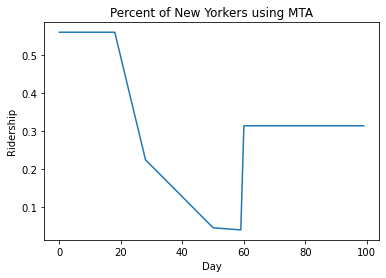

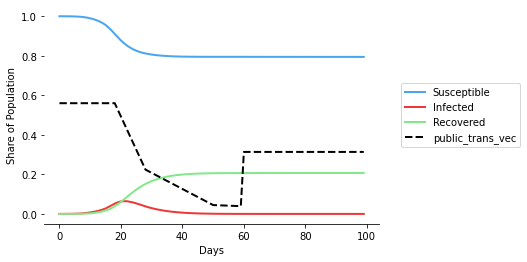

In [26]:
# NYC reopens and ridership goes back to normal
run_sim(public_trans=.56, beta=0.75, gamma=0.2, days=100, reopen_day=88, reopen_val=0.56, plot=True)

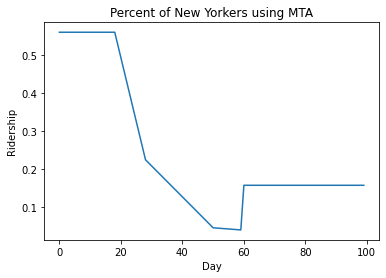

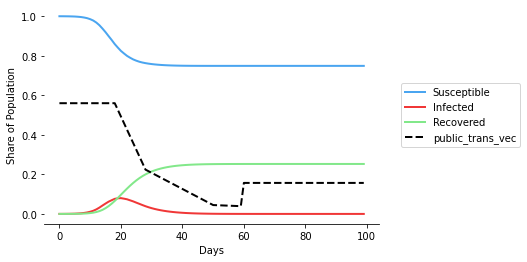

In [27]:
# NYC reopens and ridership is half of usual level
run_sim(public_trans=.56, beta=0.75, gamma=0.2, days=100, reopen_day=88, reopen_val=0.28, plot=True)

### Extra Stuff (In Progress)

https://gothamist.com/news/coronavirus-statistics-tracking-epidemic-new-york

In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import Image
import pickle 
img_path = Path.cwd()/'figures'
data_path = Path.cwd()/'data'

# create table of NYC cases, hospitalizations, and deaths, all by age group
rates_by_age = pd.read_csv(data_path/'rates_by_age.csv')
rates_by_age['cases_pct'] = (rates_by_age.cases/rates_by_age.cases.sum()).round(3)
rates_by_age['hospitalizations_pct'] = (rates_by_age.hospitalizations/rates_by_age.hospitalizations.sum()).round(3)
rates_by_age['deaths_pct'] = (rates_by_age.deaths/rates_by_age.deaths.sum()).round(3)
rates_by_age = rates_by_age[['age_group','cases','cases_pct','hospitalizations','hospitalizations_pct','deaths','deaths_pct']]
rates_by_age.to_csv(data_path/'rates_by_age.csv')
'''source:      https://www1.nyc.gov/site/doh/covid/covid-19-data.page
   other sites: https://censusreporter.org/profiles/16000US3651000-new-york-ny/
                https://www.baruch.cuny.edu/nycdata/population-geography/age_distribution.htm
                
                '''

# read OD matrix with 

In [ ]:
pd.read_pickle('./data/nyc_od.p')
od_df.to_csv('./data/nyc_od_labeled.csv')

In [ ]:
# breakdown of age, race, gender

# breakdown of essential vs non-essential workers
# https://comptroller.nyc.gov/reports/new-york-citys-frontline-workers/
#show how each group is affected proportional to their population

### Simulating death rate
By dividing the population into different age groups, we can more accurately simulate the time until recovery or death, depending on the age of the patient. The chart below contains data on coronavirus deaths by age group in New York city as of April 14th. 
<br>
Source: [https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/)

{{rates_by_age}}

In [28]:
Image(filename=img_path/'NYC_death_by_age.JPG', retina=True) 

NameError: name 'Image' is not defined

In [ ]:
rates_by_age

The share of deaths for each agr

In [ ]:
Image(filename=img_path/'NYC_age_by_county.JPG', retina=True) 